<a href="https://colab.research.google.com/github/arturjpaulo/DTI_processing_sequential/blob/main/base_norm_age_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import sklearn.metrics as m
import seaborn as sns
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.1 MB/s 


In [ ]:
vs = pd.read_csv('/content/drive/MyDrive/EINSTEIN/base_norm/structure_volumes_new_all_05.csv',decimal=',',
          na_values='na',delimiter=';')

In [ ]:
sm = pd.read_csv('/content/drive/MyDrive/EINSTEIN/base_norm/summary_metrics.csv',decimal=',',
          na_values='na',delimiter=';')

In [ ]:
sv = vs.merge(sm, on='patient_ID')

In [ ]:
sv

,patient_ID,series_id,gray_matter_cm3,white_matter_cm3,liquor_cm3,bone_cm3,soft_tissue_cm3,background_cm3,series_instance_iud,patient_sex,...,ventricle_vol_sitk,brain_jaccard_deep_sitk,ventricle_jaccard_deep_sitk,brain_dice_deep_sitk,ventricle_dice_deep_sitk,brain_Hausdorff_deep_sitk,ventricle_Hausdorff_deep_sitk,birth_date,acquisition_date,age


In [ ]:
df = sv[['patient_ID',
         'gray_matter_cm3', 'white_matter_cm3',
         'liquor_cm3', 'bone_cm3', 'soft_tissue_cm3', 'background_cm3',
         'brain_vol_sitk','ventricle_vol_sitk',
         'patient_sex',
         'age'
]]

In [ ]:
df

,patient_ID,gray_matter_cm3,white_matter_cm3,liquor_cm3,bone_cm3,soft_tissue_cm3,background_cm3,brain_vol_sitk,ventricle_vol_sitk,patient_sex,age


In [ ]:
df.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df.shape

(263, 11)

In [ ]:
df.gray_matter_cm3.isnull().sum()

19

In [ ]:
df = df[~df.gray_matter_cm3.isnull()]


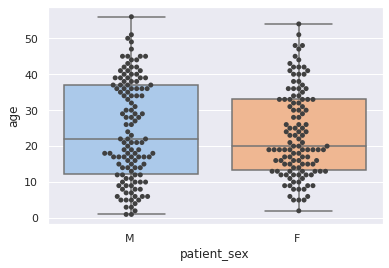

In [ ]:
#plot sex and age
from google.colab import files
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")



ax=sns.boxplot( x=df["patient_sex"], y=df["age"], palette="pastel")
ax=sns.swarmplot(x=df["patient_sex"], y=df["age"],color=".25")


plt.savefig("boxplot.pdf")
#files.download("boxplot.pdf")

In [ ]:
df['sex'] =0
df.loc[df.patient_sex == 'F ', 'sex'] = 1
df.drop('patient_sex',1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.sex.value_counts(dropna=False)

0    126
1    118
Name: sex, dtype: int64

In [ ]:
df['brain_vol_sitk']=df['brain_vol_sitk'].str.replace('.','')
df['brain_vol_sitk']=df['brain_vol_sitk'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
df['estimated_brain_vol']=df['liquor_cm3']+df['white_matter_cm3']+df['gray_matter_cm3']
df['estimated_brain_vol']

0      1363.880
1      1410.273
2      1503.617
3      1371.117
5      1354.207
         ...   
257    1410.431
258    1372.552
259    1366.708
260    1573.087
261    1279.081
Name: estimated_brain_vol, Length: 244, dtype: float64

In [ ]:
df['gray_norm']=df['estimated_brain_vol']/df['gray_matter_cm3']
df['white_norm']=df['estimated_brain_vol']/df['white_matter_cm3']
df['liquor_norm']=df['estimated_brain_vol']/df['liquor_cm3']
df['bone_norm']=df['estimated_brain_vol']/df['bone_cm3']
df['soft_norm']= df['estimated_brain_vol']/df['soft_tissue_cm3']

In [ ]:
df.shape

(244, 17)

In [ ]:
df['gray_white_matter']=df['gray_norm']/df['white_norm']
df['soft_tissue_gray']=df['soft_norm']/df['gray_norm']
df['liquor_white_matter']=df['white_norm']/df['liquor_norm']
df['liquor_gray_matter']=df['gray_norm']/df['liquor_norm']
df['bone_gray_matter']=df['bone_norm']/df['gray_norm']
df['bone_white_matter']=df['bone_norm']/df['white_norm']
df['soft_tissue_white']=df['soft_norm']/df['white_norm'] 


In [ ]:
df.columns


In [ ]:
list_drop = ['patient_ID','age', 'gray_matter_cm3', 'white_matter_cm3', 'liquor_cm3',
       'bone_cm3', 'soft_tissue_cm3', 'background_cm3', 'brain_vol_sitk',
       'ventricle_vol_sitk']
X = df.drop(list_drop,1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [ ]:
X.columns

Index(['sex', 'estimated_brain_vol', 'gray_norm', 'white_norm', 'liquor_norm',
       'bone_norm', 'soft_norm', 'gray_white_matter', 'soft_tissue_gray',
       'liquor_white_matter', 'liquor_gray_matter', 'bone_gray_matter',
       'bone_white_matter', 'soft_tissue_white'],
      dtype='object')

In [ ]:
X.columns=['Sex','Estimated intracranial volume','Gray matter volume','White matter volume','Cerebrospinal fluid','Bone volume', 
           'Soft tissue volume','Gray matter and white matter ratio', 'Soft tissue and grey matter ratio',
           'Cerebrospinal fluid and white matter ratio','Cerebrospinal fluid and gray matter ratio', 'Bone and gray matter ratio', 'Bone and white matter ratio','Soft tissue and white matter ratio']



In [ ]:
df.age.describe()

count    244.000000
mean      23.918033
std       13.032464
min        1.000000
25%       13.000000
50%       21.000000
75%       36.000000
max       56.000000
Name: age, dtype: float64

In [ ]:
y=df.age
y


0      41
1       9
2      15
3      10
5      26
       ..
257     6
258    36
259    15
260    18
261    13
Name: age, Length: 244, dtype: int64

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
#implementing Shap for random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# grid search for Random forest regressor

from sklearn.model_selection import RandomizedSearchCV


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfg = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
#extract the best hyperparemetes
rfg.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: ignored

In [ ]:
model = RandomForestRegressor(bootstrap= True,max_depth=20,max_features= 'sqrt',
                            min_samples_leaf= 1,min_samples_split= 10,n_estimators=1600)

model.fit(X_train,y_train)

explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 82it [06:40,  5.01s/it]


.values =
array([[ 5.69638175e-02, -9.74159207e-02,  7.98270238e-02, ...,
         1.89007546e+00,  1.62675826e+00,  2.53226868e-01],
       [-7.36010259e-02, -2.24491623e-03, -6.98580091e-02, ...,
         2.15038235e+00,  2.09595649e+00,  2.63201706e-01],
       [-2.60882137e-03, -6.69755476e-01,  4.31075994e-01, ...,
         2.57885897e+00,  1.72119989e+00,  4.49681187e-01],
       ...,
       [ 4.20467817e-02,  9.21731295e-02,  1.63110413e-01, ...,
         2.17824161e+00,  2.29922380e+00,  1.43993712e-01],
       [-1.08637727e-02, -4.17569914e-02,  1.52603198e-01, ...,
        -4.69894242e+00, -4.13236090e+00, -6.99310244e-01],
       [ 3.37667121e-02, -2.93968329e-02, -5.32011980e-01, ...,
        -1.10742938e+00, -1.11763626e+00,  1.18165391e-01]])

.base_values =
array([24.23425952, 24.23425952, 24.23425952, 24.23425952, 24.23425952,
       24.23425952, 24.23425952, 24.23425952, 24.23425952, 24.23425952,
       24.23425952, 24.23425952, 24.23425952, 24.23425952, 24.23425952,
 

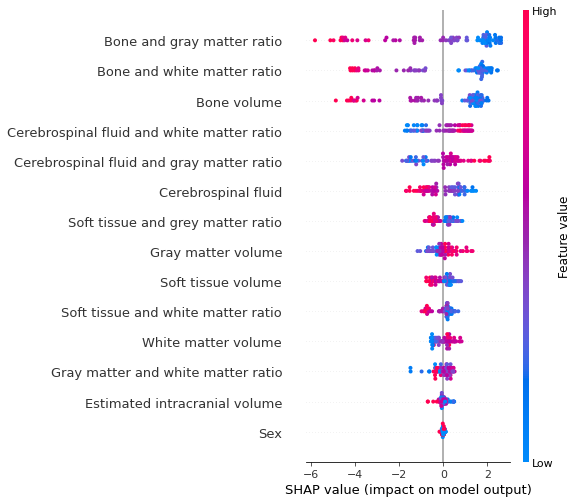

In [ ]:

from google.colab import files
import matplotlib.pyplot as plt

shap_values
#shap.plots.bar(shap_values)
shap.summary_plot(shap_values,show=False)

#fig=plt.savefig("shap_values.pdf")
#files.download("shap_values.pdf")
#shap.summary_plot(shap_values, plot_type='violin')





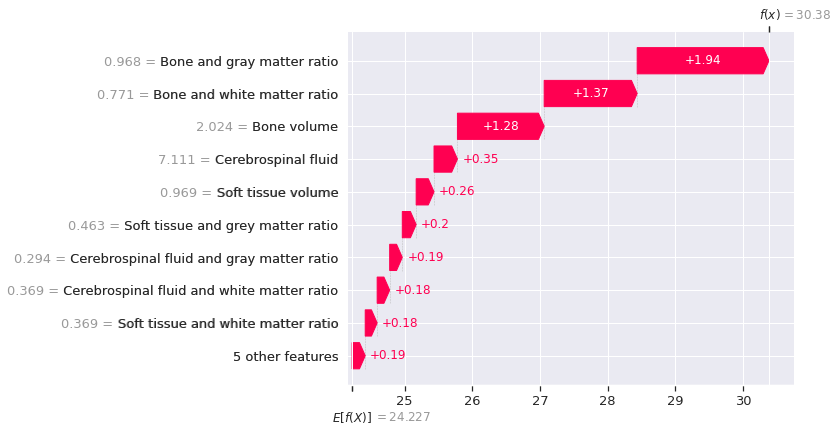

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(X[0])

KeyError: ignored

In [ ]:
from sklearn import metrics as m
p = model.predict(X_test)
m.mean_squared_error(y_test, p)


91.70218604656172

In [ ]:
m.mean_absolute_error(y_test, p)


7.571216319253323

In [ ]:
m.r2_score(y_test, p)

0.44809204429194405

Text(0, 0.5, 'Predicted Age')

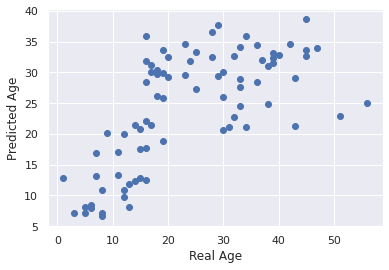

In [ ]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(y_test,p)
plt.xlabel('Real Age')
plt.ylabel('Predicted Age')

#plt.savefig("scatter_pred_vs_real.pdf")
#files.download("scatter_pred_vs_real.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

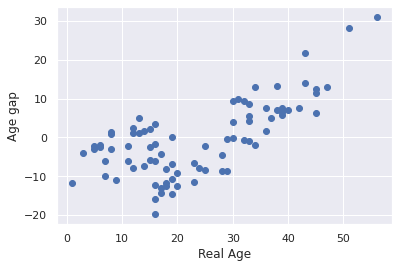

In [ ]:

import time
import matplotlib.pyplot as plt

gap= y_test-p
#gap= np.sqrt(gap ** 2)



plt.scatter(y_test,gap)
plt.xlabel('Real Age')
plt.ylabel('Age gap')

plt.savefig("agegap.pdf")
files.download("agegap.pdf")


Text(0, 0.5, 'Age gap')

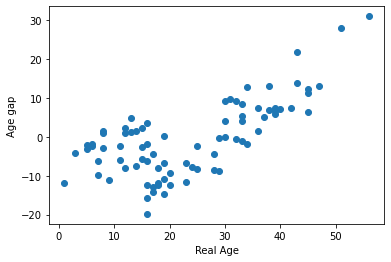

In [ ]:
import time
import matplotlib.pyplot as plt


plt.scatter(y_test,gap)
plt.xlabel('Real Age')
plt.ylabel('Age gap')

In [ ]:
p

array([30.57356905, 32.06161101, 35.80224077, 28.95346635, 35.72694034,
       37.42535952, 20.92535521, 32.22976165, 34.59584076, 30.28459869,
       29.61450601, 21.20862667, 25.88353207, 22.09225971, 11.79265959,
       34.304905  , 30.09846083, 22.92419141, 34.39286972, 26.11315554,
       27.44459416, 29.58341331, 29.55469607, 33.45127003, 20.89662766,
       30.22540804, 26.76641864,  8.22737806, 30.98411252, 32.31126127,
       32.81404148, 16.71652484, 24.94363099,  7.8244032 , 29.17321572,
       20.58716811, 21.34253863, 30.46931814, 31.61982396, 12.96424154,
       28.81064065, 31.52688453, 10.89172217, 21.09897332, 20.22728266,
       24.58383093, 31.20518806, 12.57554424, 24.3686728 , 34.44728427,
       38.63343669, 32.04249898, 33.71308868, 13.27286078,  7.07321052,
        7.03042738, 23.04111765, 25.95790193, 34.26829002, 12.88986188,
        6.52807027, 17.92939792, 16.72549629,  9.62369016,  8.07160935,
       21.19306535, 17.40423426, 33.27953738, 20.63016209, 36.60

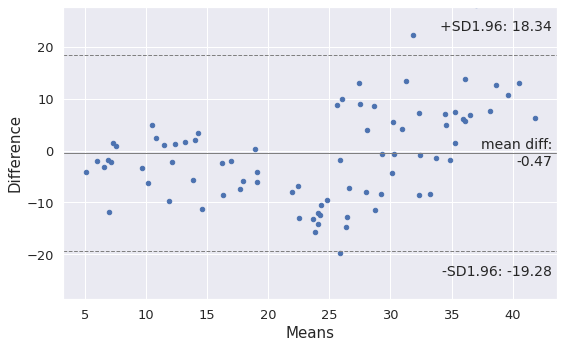

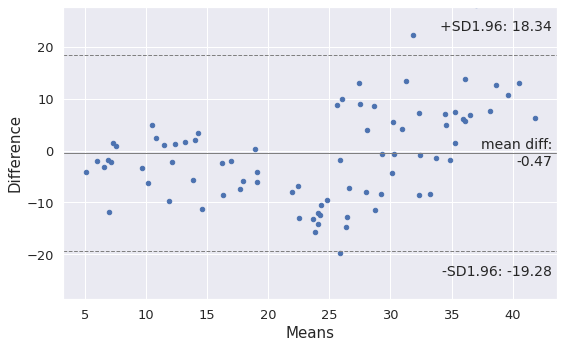

In [ ]:
#create Bland-Altman plot 
import statsmodels.api as sm
import matplotlib.pyplot as plt


ax.set_ylabel('Differed real age')              
f, ax = plt.subplots(1, figsize = (8,5))

sm.graphics.mean_diff_plot(y_test,p, ax = ax)

#display Bland-Altman plot
#plt.show()

#plt.savefig("altman.pdf")
#files.download("altman.pdf")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


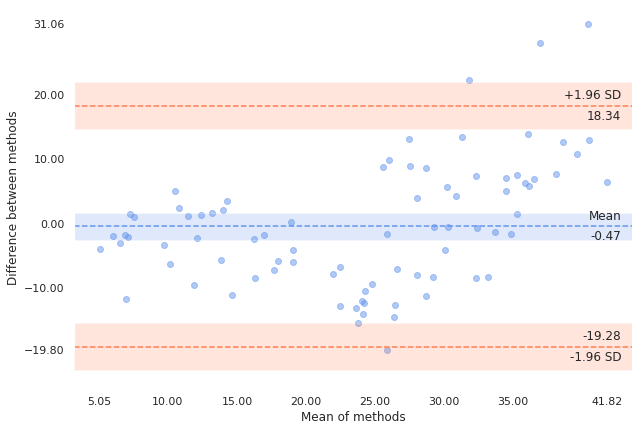

In [ ]:
!pip install pyCompare
import pyCompare

pyCompare.blandAltman(y_test, p)

In [ ]:
#run regression model
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm


# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# prediction with sklearn
# New_Interest_Rate = 2.75
# New_Unemployment_Rate = 5.3
# print ('Predicted Stock Index Price: \n', regr.predict([[New_Interest_Rate ,New_Unemployment_Rate]]))

# # with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 17.833095779562083
Coefficients: 
 [ 0.00000000e+00 -8.27257460e-01 -6.38166439e-03  3.99435017e+01
 -4.25778970e+01  7.20386859e+00 -2.65802896e+00  3.35887578e+02
 -3.09175109e+01 -3.96240872e+02  6.47230225e+01  7.08610126e+01
  4.22799688e+01 -8.06237570e+01 -3.63792920e+02]
                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     17.98
Date:                Thu, 21 Jul 2022   Prob (F-statistic):           2.02e-28
Time:                        12:16:28   Log-Likelihood:                -886.63
No. Observations:                 244   AIC:                             1801.
Df Residuals:                     230   BIC:                             1850.
Df Model:                          13                                      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


ImportError: ignored

In [ ]:
## fim ##

NameError: ignored

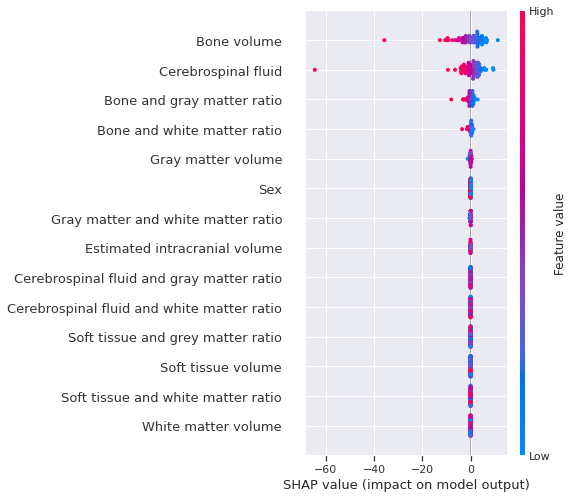

In [ ]:

from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X_train, y_train)
p = regr.predict(X_test)


explainer = shap.Explainer(regr.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)
shap.summary_plot(shap_values)


#

In [ ]:
m.mean_squared_error(y_test, p)

174.98657667775078

In [ ]:
m.mean_absolute_error(y_test, p)

8.977415439227604

In [ ]:
m.r2_score(y_test, p)

-0.05315356126332427

Text(0, 0.5, 'Predicted Age')

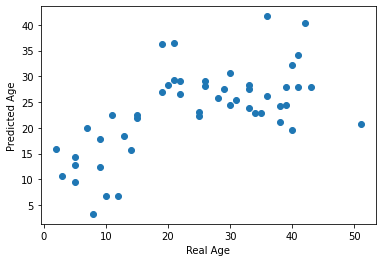

In [ ]:
import time
import matplotlib.pyplot as plt


plt.scatter(y_test,p)
plt.xlabel('Real Age')
plt.ylabel('Predicted Age')

In [ ]:
# from sklearn.model_selection import cross_validate
# from sklearn.metrics import recall_score

# print(cross_validate(estimator=regr_cv,X=X, y=y,))

SyntaxError: ignored

In [ ]:
p = regr.predict(X_test)

In [ ]:
from sklearn import metrics as m

In [ ]:
m.mean_squared_error(y_test, p)

76.03546855565352

In [ ]:
m.mean_absolute_error(y_test, p)

6.735848805498545

In [ ]:
m.r2_score(y_test, p)

0.04590954273780956

In [ ]:
brainAgeGap2  = p-test_set['age']

In [ ]:
# 1. Testar novos modelos = RF, AdaBoost, MLPRegressor (RNA)
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# 2. Fazer feature importances do RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr_RF = RandomForestRegressor(n_estimators=100,random_state=0)
regr_RF.fit(X_train, y_train)
p = regr_RF.predict(X_test)

In [ ]:
# sqrt()

In [ ]:
m.mean_squared_error(y_test, p)

76.03546855565352

In [ ]:
m.mean_absolute_error(y_test, p)

6.0409523809523815

In [ ]:
m.r2_score(y_test, p)

0.31372773127309395

In [ ]:
importances = regr_RF.feature_importances_

In [ ]:
feature_names = X_train.columns

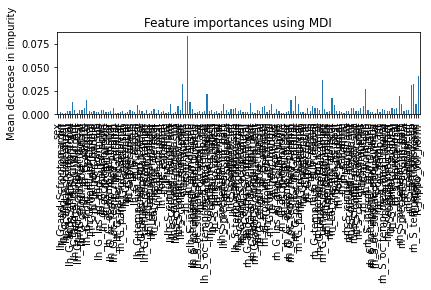

In [ ]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Text(0, 0.5, 'Predicted Age')

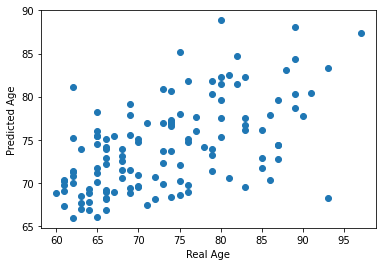

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict

plt.scatter(y_test,p)
plt.xlabel('Real Age')
plt.ylabel('Predicted Age')

In [ ]:
#plot_regression_results(ax,y_test,p,"age predictor", )

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Procurar os melhores hiperparâmetros
# Criando o modelo base para ajustar
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfg = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rfg.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rfg.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [ ]:
rfr = RandomForestRegressor(bootstrap= True,max_depth=100,max_features= 'auto',
                            min_samples_leaf= 1,min_samples_split= 2,n_estimators=800)

In [ ]:
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=800)

In [ ]:
p_rf = rfr.predict(X_test)

In [ ]:
m.r2_score(y_test, p_rf)

0.32124940473779406

In [ ]:
m.mean_absolute_error(y_test, p_rf)

5.970843253968254

In [ ]:
m.mean_squared_error(y_test, p_rf)

54.09248059275793

In [ ]:
## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
ada = AdaBoostRegressor(random_state=0)

In [ ]:
ada.fit(X_train, y_train)

AdaBoostRegressor(random_state=0)

In [ ]:
p_ada = ada.predict(X_test)

In [ ]:
m.r2_score(y_test, p_ada)

0.24327368772658076

In [ ]:
m.mean_absolute_error(y_test, p_ada)

6.283216681127984

In [ ]:
m.mean_squared_error(y_test, p_ada)

60.30669239393658

In [ ]:
#Adaboost random CV search 


from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

pre_gs_inst =AdaBoostRegressor()
ada_g = RandomizedSearchCV(pre_gs_inst , param_distributions = param_dist, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1);
ada_g.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100]},
                   random_state=42, verbose=2)

In [ ]:
ada_g.best_params_

{'learning_rate': 1, 'loss': 'square', 'n_estimators': 100}

In [ ]:
best_gs_inst =AdaBoostRegressor(learning_rate= 1, loss= 'square', n_estimators= 100)
best_gs_inst.fit(X_train,y_train)

AdaBoostRegressor(learning_rate=1, loss='square', n_estimators=100)

In [ ]:
p_ada_g=best_gs_inst.predict(X_test)


In [ ]:
m.r2_score(y_test, p_ada_g)

0.3026278133019338

In [ ]:
m.mean_absolute_error(y_test, p_ada_g)

5.87322640568855

In [ ]:
m.mean_squared_error(y_test, p_ada_g)

55.57651328515124

In [ ]:
#Ajustar os melhores parâmetros do Adaboost


In [ ]:
#MLP Classsifier

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

In [ ]:
mlpr = MLPRegressor(random_state=1, max_iter=500)

In [ ]:
mlpr.fit(X_train, y_train)

MLPRegressor(max_iter=500, random_state=1)

In [ ]:
p_mlp = mlpr.predict(X_test)

In [ ]:
m.r2_score(y_test, p_mlp,force_finite=False)

-1.1120391771793239

In [ ]:
m.mean_absolute_error(y_test, p_mlp)

10.312404587415577

In [ ]:
m.mean_squared_error(y_test, p_mlp)

168.31725673637638

In [ ]:
# MLP CV Search

from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.00182466e+000 -6.13398232e+001 -1.95661784e+000 -6.08434344e+001
 -9.41604219e-001 -6.15485664e+001 -1.94879383e+000 -5.94491232e+001
 -3.25999188e-001 -4.65587265e+001 -4.64043658e-001 -4.72951763e+001
 -9.23494125e-001 -6.24289990e+001 -2.30136252e+000 -6.08754439e+001
 -1.03631490e+000 -6.18436819e+001 -1.82802290e+000 -6.06546179e+001
 -1.70914863e-001 -4.63101928e+001 -4.29238014e-001 -4.64230912e+001
              nan -2.59409587e+000 -6.75531682e-001 -2.46342480e+000
             -inf -2.18562382e+000 -1.93727179e+252 -2.12156710e+000
 -3.98737525e+001 -1.66973255e+000 -1.95014145e+001 -1.54656784e+000
              nan -2.55469684e+000             -inf -2.60499914e+000
 -3.94136127e+274 -2.06801556e+000 -2.56692033e+001 -2.00583538e+000
 -2.76609621e+001 -1.55984400e+000 -2.66217944e+001 -1.43457375e+000]
  category=UserWarning,
/usr/loc

GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [ ]:
clf.best_params_


{'activation': 'tanh',
 'alpha': 0.05,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'sgd'}

In [ ]:
#avaliando MLP com melhores parmetros
mlp_g_best=MLPRegressor(activation= 'tanh',alpha= 0.05, hidden_layer_sizes= (100,),learning_rate= 'constant', solver= 'sgd')


In [ ]:
mlp_g_best.fit(X_train,y_train)

MLPRegressor(activation='tanh', alpha=0.05, solver='sgd')

In [ ]:
p_mlp = mlp_g_best.predict(X_test)


In [ ]:
m.r2_score(y_test, p_mlp, force_finite=False))


-0.0049620314238219

In [ ]:
m.mean_absolute_error(y_test, p_mlp)


7.538209107036237

In [ ]:
m.mean_absolute_error(y_test, p_mlp)


7.538209107036237

In [ ]:
m.mean_squared_error(y_test, p_mlp)

80.08963757925204